# 쇼핑몰 지점별 매출액 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style='white')

In [3]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측\\쇼핑몰지점별-매출액-EDA모델링'

In [4]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측')

In [265]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [266]:
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 데이터 전처리 및 파생변수 생성

- Data 변수를 날짜 형식으로 변경하여 연, 월, 일 변수를 생성

`-` 또한 2010년을 기준으로 연월일을 하루 단위로 변환하여 2010년으로부터 며칠이 지났는지를 알 수 있는 변수를 생성하겠다  

In [267]:
def get_date(df) -> None:
    """df['Date']에서 연, 월, 일 변수를 생성""" 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

In [268]:
get_date(df)
get_date(test)

In [269]:
df['Day_Range'] = (df['Date'] - pd.datetime(2010, 1, 1)).dt.days
test['Day_Range'] = (test['Date'] - pd.datetime(2010, 1, 1)).dt.days

- 공휴일 변수를 숫자로 변경

In [270]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x else 0)

- 화씨를 섭씨로 변환

In [271]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9
test['Temperature'] = (test['Temperature'] - 32) * 5/9

- 프로모션의 결측치를 $-1$로 대체

In [272]:
df.fillna(value=-1, inplace=True)
test.fillna(value=-1, inplace=True)

- 총 프로모션 비용 변수 생성

In [273]:
df['Promotion_Cost'] = df[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)
test['Promotion_Cost'] = test[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)

- month의 몇 번재 week인지 나타내는 변수 생성

In [274]:
df['WeekOfMonth'] = df['Day'].apply(lambda x: (x-1) // 7 + 1)
test['WeekOfMonth'] = test['Day'].apply(lambda x: (x-1) // 7 + 1)

- 크리스마스가 몇 주일 남았는지 나타내는 변수를 생성

`-` 크리스마스는 12월 4주차에 존재함

`-` 12월 3주차는 2, 4주차는 3, 5주차는 1, 그 외는 0으로 코딩 (매출액이 기준)

In [275]:
def christmas_week(date):
    month = date.month
    week_of_month = (date.day-1) // 7 + 1
    if month == 12:
        if week_of_month == 3:
            return 2
        elif week_of_month == 4:
            return 3
        elif week_of_month == 5:
            return 1
    return 0

In [276]:
df['IsChristmasWeek'] = df['Date'].apply(lambda date: christmas_week(date))
test['IsChristmasWeek'] = test['Date'].apply(lambda date: christmas_week(date))

In [277]:
df.head()

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Day,Day_Range,Promotion_Cost,WeekOfMonth,IsChristmasWeek
0,1,2010-05-02,5.727778,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1643690.90,2010,5,2,121,-5.0,1,0
1,1,2010-12-02,3.616667,2.548,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,1,1641957.44,2010,12,2,335,-5.0,1,0
2,1,2010-02-19,4.405556,2.514,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1611968.17,2010,2,19,49,-5.0,3,0
3,1,2010-02-26,8.127778,2.561,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1409727.59,2010,2,26,56,-5.0,4,0
4,1,2010-05-03,8.055556,2.625,-1.0,-1.0,-1.0,-1.0,-1.0,8.106,0,1554806.68,2010,5,3,122,-5.0,1,0


- 쇼핑몰 지점 군집화

In [17]:
cor_list = []
for store in list(range(1, 46)):
    df_ = df.query('Store == @store')
    cor = np.corrcoef(df_['Day_Range'], df_['Weekly_Sales'])[1, 0]
    cor_list.append(cor)

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

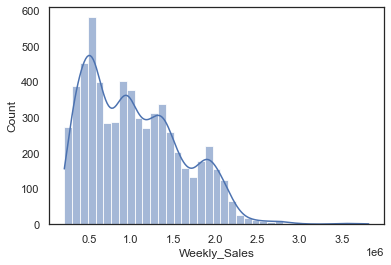

In [18]:
sns.histplot(data=df, x='Weekly_Sales', kde=True)

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

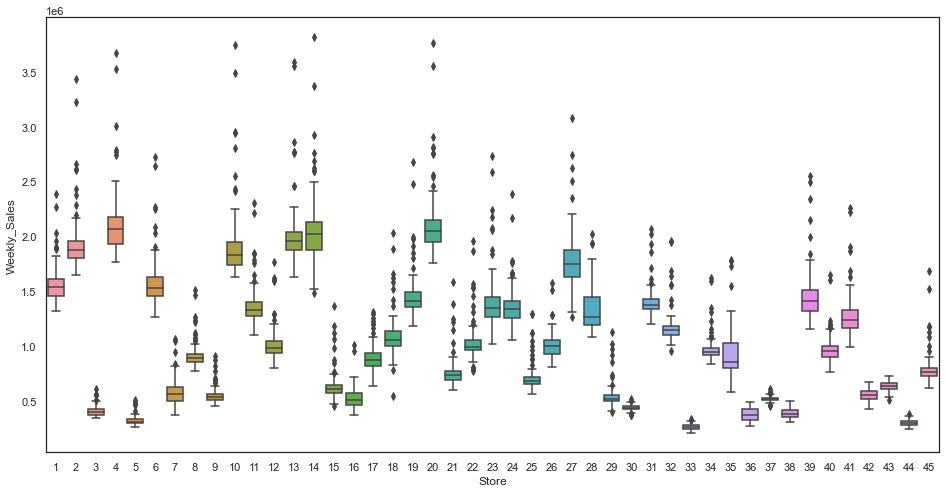

In [19]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, y='Weekly_Sales', x='Store')

`-` 비슷한 분포를 띄는 쇼핑몰 지점을 군집화하자 (매출액의 중앙값과 IQR, 지난 일수와의 상관계수가 비슷해야 함)

In [18]:
tmp = df.groupby(by='Store').agg({'Weekly_Sales':[np.median, lambda x: np.quantile(x, q=0.75) - np.quantile(x, q=0.25)]}).\
        reset_index().rename(columns={'<lambda_0>':'IQR'}).melt(id_vars='Store').\
        rename(columns={'variable_1':'statistic'}).drop('variable_0', axis=1)

<AxesSubplot:>

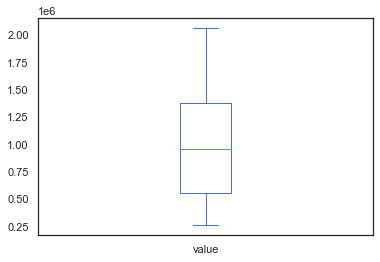

In [21]:
tmp.query('statistic == "median"').value.plot.box()

<AxesSubplot:>

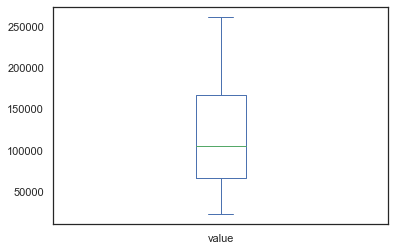

In [22]:
tmp.query('statistic == "IQR"').value.plot.box()

`-` 매출액의 중앙값과 사분위수 범위가 비슷한 쇼핑몰 지점끼리 군집화하겠다

`-` 나의 능지 문제로 일단은 일일이 분류하겠다

`-` 나중에 함수로 만들든 클래스로 만들든 해가지고 이를 사용해 분류하겠다


In [19]:
median_bins = [-np.inf]
for i in range(1, 8):
    value = np.quantile(tmp.query('statistic == "median"').value, q=i/8)
    median_bins.append(value)
median_bins.append(np.inf)

In [20]:
cuts = pd.cut(tmp.query('statistic == "median"').value, bins=median_bins, labels=list(range(1, 9)))

In [21]:
store_df = pd.DataFrame(data=range(1, 46), columns=['Store'])

In [22]:
store_df['Cut'] = cuts

In [23]:
store_df = store_df.merge(tmp.query('statistic == "median"').drop('statistic', axis=1)).\
                    rename(columns={'value':'median'}).\
                    merge(tmp.query('statistic == "IQR"').drop('statistic', axis=1)).\
                    rename(columns={'value':'IQR'})

In [34]:
store_df.sort_values(['Cut','median'])

,Store,Cut,median,IQR
32,33,1,258427.39,32983.995
43,44,1,296947.06,33261.035
4,5,1,310013.11,35965.040
35,36,1,374182.04,102919.525
37,38,1,378539.17,63063.615
2,3,1,394918.83,52937.615
29,30,2,438068.71,26957.145
15,16,2,509942.56,102416.915
36,37,2,517546.69,22461.165
28,29,2,518628.42,59120.110


- 사후처리

`-` 군집내에서 쇼핑몰 지점별 중앙값의 차이가 큰 경우 군집을 쪼개겠다

`-` 또한, 군집내에서 사분위수 범위가 유사한 것끼리 다시 군집화하겠다

`-` 성능을 올리기 위해선 필수이다

|군집 번호| 매출액의 범위|쇼핑몰 지점|
|:-:|:-:|:-:|
|1|$<416493$|33, 44, 5, 36, 38, 3|
|2|$<556046$|30, 16, 37, 29, 9 ,42|
|3|$<752464$|7, 15, 43, 25, 21|
|4|$<954233$|45, 35, 17, 8, 34, 40|
|5|$<1191838$|12, 22, 26, 18, 32|
|6|$<1378340$|41, 28, 11, 24, 23, 31|
|7|$<1786338$|19, 39, 6, 1, 27|
|8|$\geq 1786338$|10, 2, 13, 14, 20, 4|

`-` 그룹 8 다시 분류

2와 10, 13, 14, 20, 4

`-` 그룹 7 다시 분류

19, 39, 6,  1, 27

`-` 그룹 6 다시 분류

24, 23, 31, 11과 24, 41, 28

`-` 그룹 5 다시 분류

18, 32, 12, 22, 26

`-` 그룹 4 다시 분류

34와 40, 17, 35, 8

`-` 그룹 3 다시 분류

45(그룹3과 4의 경계)와 21, 25, 43(특별함), 7, 15

`-` 그룹 2 다시 분류

42(특별함), 37(특별함), 30(특별함), 16, 29, 9

`-` 그룹 1 다시 분류

36(하강), 38(상승), 33(특별함), 5, 44

## 모델링

In [164]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [127]:
SEED = 22

In [128]:
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true - pred)))
    return score

In [202]:
def OOF_predict(model, X, y, test, SKfold, stratify=None, original_score=False):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    train, valid에 대한 RMSE score와 예측한 test를 return
    """ 
    model_valid_SAE = []
    model_train_score = []
    model_valid_score = []
    model_pred = np.zeros(shape=(test.shape[0]))
    
    if stratify is not None:
        split_fold = SKfold.split(X, X[stratify])
    else:
        split_fold = SKfold.split(X)

    for i, (train_idx, valid_idx) in enumerate(split_fold):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
        
        ## 모델 적합
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  #eval_metric='rmse', 
                  verbose=0,
                  early_stopping_rounds=200
                 )
        
        ## prediction
        train_pred = model.predict(X_train) ## train
        valid_pred = model.predict(X_valid) ## valid
        test_pred = model.predict(test) ## test
        
        model_train_score.append(RMSE(y_train, train_pred)) ## train RMSE
        model_valid_score.append(RMSE(y_valid, valid_pred)) ## valid RMSE
        model_valid_SAE.append(np.square(y_valid, valid_pred)) ## square of absolute error
        model_pred += test_pred / SKfold.n_splits ## test 예측값(k Fold)
              
    if original_score:
        return model_train_score, model_valid_score, model_valid_SAE, model_pred
    return model_train_score, model_valid_score, model_pred

`-` 랜덤 포레스트 모델과 그래디언트 부스팅 모델은 성능이 좋지 않았다

In [181]:
CB = CatBoostRegressor(use_best_model=True,
                       random_state=SEED,
                       #min_data_in_leaf=3,
                       verbose=0)

In [137]:
CB = CatBoostRegressor(n_estimators=3000,
                       learning_rate=0.03,
                       max_depth=7,
                       use_best_model=True,
                       random_state=SEED,
                       verbose=0)

XGB = XGBRegressor(n_estimators=3000,
                   learning_rate=0.03,
                   max_depth=6,
                   random_state=SEED)

LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.03,
                     max_depth=10,
                     min_child_samples=2,
                     random_state=SEED)

- Month 변수를 1월, 12월, 그 외 나머지로 구성

In [259]:
# df['Month2'] = df['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))
# test['Month2'] = test['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))

- 사용할 변수

`-` 데이터가 일주일 간격으로 존재하여 `Day` 변수도 추가했다 (하루 간격이었으면 제외했음)

`-` `Day_Range` 변수는 기온에 대한 정보와 날짜 정보를 담고 있다

In [260]:
features = [
            'Store',
            'Temperature',
            'Fuel_Price',
            'Unemployment',
            #'IsHoliday',
            #'Promotion_Cost',
            'Year',
            'Day',
            'IsChristmasWeek',
            'Month',
            #'Month2',
            'WeekOfMonth',
            'Day_Range',
           ]

In [261]:
target = df['Weekly_Sales']

In [262]:
df2 = df[features] ## 교호작용 X
test2 = test[features]

In [263]:
k = 5
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED*2)

- 모델 학습

`-` RF, EXT, GD 모델의 성능은 좋지 않다

- RF

In [106]:
_, RF_valid_RMSE1, RF_test_pred1 = OOF_predict(RF, df2, target, test2, skfold1, stratify='Store')
_, RF_valid_RMSE2, RF_test_pred2 = OOF_predict(RF, df2, target, test2, skfold2, stratify='Store')
print(f'{RF.__class__.__name__} -> Mean: {np.mean(RF_valid_RMSE1 + RF_valid_RMSE2)}, Std: {np.std(RF_valid_RMSE1 + RF_valid_RMSE2)}')

RandomForestRegressor -> Mean: 161264.4850842501, Std: 8598.05339970493


- EXT

In [105]:
_, EXT_valid_RMSE1, EXT_test_pred1 = OOF_predict(EXT, df2, target, test2, skfold1, stratify='Store')
_, EXT_valid_RMSE2, EXT_test_pred2 = OOF_predict(EXT, df2, target, test2, skfold2, stratify='Store')
print(f'{EXT.__class__.__name__} -> Mean: {np.mean(EXT_valid_RMSE1 + EXT_valid_RMSE2)}, Std: {np.std(EXT_valid_RMSE1 + EXT_valid_RMSE2)}')

ExtraTreesRegressor -> Mean: 154702.36835147176, Std: 8932.41281145462


- GD

In [98]:
_, GD_valid_RMSE1, GD_test_pred1 = OOF_predict(GD, df2, target, test2, skfold1, stratify='Store')
_, GD_valid_RMSE2, GD_test_pred2 = OOF_predict(GD, df2, target, test2, skfold2, stratify='Store')
print(f'{GD.__class__.__name__} -> Mean: {np.mean(GD_valid_RMSE1 + GD_valid_RMSE2)}, Std: {np.std(GD_valid_RMSE1 + GD_valid_RMSE2)}')

GradientBoostingRegressor -> Mean: 107864.66071510027, Std: 6645.629863025874


- CB

In [141]:
_, CB_valid_RMSE1, CB_test_pred1 = OOF_predict(CB, df2, target, test2, skfold1, stratify='Store')
_, CB_valid_RMSE2, CB_test_pred2 = OOF_predict(CB, df2, target, test2, skfold2, stratify='Store')
print(f'{CB.__class__.__name__} -> Mean: {np.mean(CB_valid_RMSE1 + CB_valid_RMSE2)}, Std: {np.std(CB_valid_RMSE1 + CB_valid_RMSE2)}')

CatBoostRegressor -> Mean: 82722.0130633474, Std: 7682.658217905672


- XGB

In [142]:
_, XGB_valid_RMSE1, XGB_test_pred1 = OOF_predict(XGB, df2, target, test2, skfold1, stratify='Store')
_, XGB_valid_RMSE2, XGB_test_pred2 = OOF_predict(XGB, df2, target, test2, skfold2, stratify='Store')
print(f'{XGB.__class__.__name__} -> Mean: {np.mean(XGB_valid_RMSE1 + XGB_valid_RMSE2)}, Std: {np.std(XGB_valid_RMSE1 + XGB_valid_RMSE2)}')

XGBRegressor -> Mean: 95990.43268713747, Std: 10544.859985498664


- LGBM

In [140]:
_, LGBM_valid_RMSE1, LGBM_test_pred1 = OOF_predict(LGBM, df2, target, test2, skfold1, stratify='Store')
_, LGBM_valid_RMSE2, LGBM_test_pred2 = OOF_predict(LGBM, df2, target, test2, skfold2, stratify='Store')
print(f'{LGBM.__class__.__name__} -> Mean: {np.mean(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}, Std: {np.std(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}')

LGBMRegressor -> Mean: 85635.52555090468, Std: 9292.748045859838


`-` LGBM 모델의 성능이 가장 우수하다

- test 예측 및 제출

`-` test 데이터의 경우 행이 180개로 train 데이터에 비해 매우 적다

`-` 연도는 2012년만 존재하며 월의 경우 5월, 10월, 12월만 존재한다

`-` 오버피팅을 주의해야 한다

`-` LGBM 모델과 XGB 모델은 성능이 좋지 않았으며 Catboost 모델의 성능은 나쁘지 않다

In [142]:
submission['Weekly_Sales'] = (CB_test_pred1 + CB_test_pred2) / 2
submission.head()

,id,Weekly_Sales
0,1,1.629705e+06
1,2,1.556559e+06
2,3,1.258371e+06
3,4,1.271491e+06
4,5,1.837574e+06


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

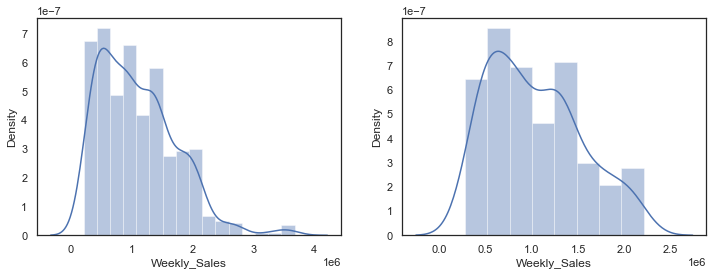

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [403]:
# submission.to_csv('./Data/submission5.csv', index=False)

## 쇼핑몰 지점별 모델 생성

`-` 쇼핑몰마다 주간 매출액의 분포가 상이하여 비슷한 분포를 띄는 쇼핑몰끼리 그룹화하려고 했다

`-` 그런데 굳이 그룹화 하지않고 쇼핑몰 지점에 따른 모델을 생성하여 학습하고자 했다 

`-` 원핫인코딩을 사용하면 피쳐의 개수가 너무 많아져서 쇼핑몰 지점마다 모델을 생성

`-` 기존의 존재하지 않는 새로운 쇼핑몰이라면 전체 데이터로 학습시킨 모델을 사용했다

`-` 그러나 test 데이터에서 새로운 쇼핑몰은 등장하지 않았다

In [200]:
k = 15
skfold1 = KFold(k, shuffle=True, random_state=SEED)
skfold2 = KFold(k, shuffle=True, random_state=SEED*2)

In [206]:
CB = CatBoostRegressor(use_best_model=True,
                       random_state=SEED,
                       #min_data_in_leaf=3,
                       verbose=0)

In [160]:
XGB = XGBRegressor(random_state=SEED)

In [180]:
LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.1,
                     #max_depth=7,
                     min_child_samples=3,
                     random_state=SEED)

`-` XGB 기본: 88841, CB 기본: 81941

In [166]:
valid_RMSE = []
preds = {}
model = CB
for store in tqdm(range(1, 46)):
    df3 = df.query('Store == @store')
    target = df3['Weekly_Sales']
    df3 = df3[features].drop('Store', axis=1)
    test3 = test2.query('Store == @store')
    test3 = test3[features].drop('Store', axis=1)
    _, model_valid_RMSE, model_test_pred = OOF_predict(model, df3, target, test3, skfold1)
    _, model_valid_RMSE2, model_test_pred2 = OOF_predict(model, df3, target, test3, skfold2)
    valid_RMSE.extend(model_valid_RMSE + model_valid_RMSE2)
    preds[store] = (model_test_pred + model_test_pred2) / 2
    print(f'{store} -> Mean: {np.mean(model_valid_RMSE + model_valid_RMSE2)} Std: {np.std(model_valid_RMSE + model_valid_RMSE2)}')
    
print(f'쇼핑몰 지점별 RMSE의 평균: {np.mean(valid_RMSE)}')

  2%|█▊                                                                                 | 1/45 [00:27<20:17, 27.67s/it]

1 -> Mean: 87136.37237113387 Std: 42906.36070461575


  4%|███▋                                                                               | 2/45 [00:58<21:10, 29.54s/it]

2 -> Mean: 125972.18912672275 Std: 69655.00477091299


  7%|█████▌                                                                             | 3/45 [01:24<19:36, 28.01s/it]

3 -> Mean: 27573.181003135956 Std: 14320.44155524115


  9%|███████▍                                                                           | 4/45 [01:51<18:52, 27.63s/it]

4 -> Mean: 128853.80890121698 Std: 75264.75055134513


 11%|█████████▏                                                                         | 5/45 [02:16<17:50, 26.77s/it]

5 -> Mean: 23970.64349514304 Std: 14863.03063383844


 13%|███████████                                                                        | 6/45 [02:47<18:07, 27.88s/it]

6 -> Mean: 118981.5081593678 Std: 59400.215720738146


 16%|████████████▉                                                                      | 7/45 [03:18<18:24, 29.06s/it]

7 -> Mean: 60445.49120533374 Std: 28207.93947789523


 18%|██████████████▊                                                                    | 8/45 [03:43<17:08, 27.79s/it]

8 -> Mean: 63993.352820449116 Std: 32861.29611724553


 20%|████████████████▌                                                                  | 9/45 [04:10<16:26, 27.41s/it]

9 -> Mean: 40778.330457319025 Std: 22115.354638494373


 22%|██████████████████▏                                                               | 10/45 [04:34<15:30, 26.58s/it]

10 -> Mean: 170558.5360596979 Std: 89764.64262788805


 24%|████████████████████                                                              | 11/45 [05:04<15:34, 27.49s/it]

11 -> Mean: 91001.4616396185 Std: 39464.96393918547


 27%|█████████████████████▊                                                            | 12/45 [05:33<15:25, 28.04s/it]

12 -> Mean: 77696.86990670655 Std: 46152.790646844565


 29%|███████████████████████▋                                                          | 13/45 [06:00<14:44, 27.63s/it]

13 -> Mean: 144605.5559120764 Std: 79348.74087201459


 31%|█████████████████████████▌                                                        | 14/45 [06:28<14:19, 27.73s/it]

14 -> Mean: 175316.86325908324 Std: 86465.53857909166


 33%|███████████████████████████▎                                                      | 15/45 [06:59<14:25, 28.85s/it]

15 -> Mean: 62094.414482111075 Std: 39061.923128374874


 36%|█████████████████████████████▏                                                    | 16/45 [07:30<14:14, 29.46s/it]

16 -> Mean: 42158.31181836835 Std: 17394.997821793288


 38%|██████████████████████████████▉                                                   | 17/45 [07:55<13:03, 27.98s/it]

17 -> Mean: 80584.39334759736 Std: 33104.64659345497


 40%|████████████████████████████████▊                                                 | 18/45 [08:23<12:35, 27.99s/it]

18 -> Mean: 101186.65222009926 Std: 47832.23461653946


 42%|██████████████████████████████████▌                                               | 19/45 [08:49<11:56, 27.55s/it]

19 -> Mean: 107215.96157995806 Std: 44112.30208084639


 44%|████████████████████████████████████▍                                             | 20/45 [09:14<11:09, 26.80s/it]

20 -> Mean: 157369.86787027447 Std: 75828.31241124019


 47%|██████████████████████████████████████▎                                           | 21/45 [09:44<11:04, 27.70s/it]

21 -> Mean: 70389.29604537616 Std: 41325.62900106441


 49%|████████████████████████████████████████                                          | 22/45 [10:15<10:59, 28.68s/it]

22 -> Mean: 90651.64796348017 Std: 45400.63131211876


 51%|█████████████████████████████████████████▉                                        | 23/45 [10:45<10:38, 29.02s/it]

23 -> Mean: 132779.78695684546 Std: 51985.94597478217


 53%|███████████████████████████████████████████▋                                      | 24/45 [11:13<10:06, 28.89s/it]

24 -> Mean: 93892.51792191491 Std: 38820.365021093014


 56%|█████████████████████████████████████████████▌                                    | 25/45 [11:41<09:30, 28.52s/it]

25 -> Mean: 62813.20733848399 Std: 34016.020578219155


 58%|███████████████████████████████████████████████▍                                  | 26/45 [12:14<09:23, 29.68s/it]

26 -> Mean: 55513.37034881858 Std: 24718.633826624875


 60%|█████████████████████████████████████████████████▏                                | 27/45 [12:44<08:57, 29.88s/it]

27 -> Mean: 149446.42596733 Std: 70524.75331003303


 62%|███████████████████████████████████████████████████                               | 28/45 [13:17<08:44, 30.87s/it]

28 -> Mean: 102382.07387207026 Std: 49161.20773172021


 64%|████████████████████████████████████████████████████▊                             | 29/45 [13:54<08:44, 32.75s/it]

29 -> Mean: 58675.822329772265 Std: 34276.89739371162


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [14:40<09:09, 36.64s/it]

30 -> Mean: 14046.104410991213 Std: 5367.547765257223


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [15:19<08:41, 37.24s/it]

31 -> Mean: 70754.40366883486 Std: 42904.0464101235


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [15:49<07:35, 35.07s/it]

32 -> Mean: 78527.27380009365 Std: 44600.055168808256


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [16:23<06:56, 34.74s/it]

33 -> Mean: 10524.876569293496 Std: 2559.8020325992125


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [16:46<05:46, 31.49s/it]

34 -> Mean: 58265.69088003491 Std: 34641.01111907563


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [17:15<05:04, 30.48s/it]

35 -> Mean: 113927.87309992357 Std: 70774.00565415504


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [17:46<04:37, 30.85s/it]

36 -> Mean: 15490.505311467618 Std: 4433.484335439257


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [18:11<03:51, 28.91s/it]

37 -> Mean: 15672.809191441405 Std: 6211.636902050337


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [18:42<03:26, 29.48s/it]

38 -> Mean: 12570.420214832868 Std: 4457.985873759711


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [19:09<02:53, 28.99s/it]

39 -> Mean: 118267.50684978096 Std: 68284.01142169457


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [19:39<02:25, 29.19s/it]

40 -> Mean: 57376.17794472966 Std: 20217.913057509955


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [20:07<01:55, 28.79s/it]

41 -> Mean: 102029.5555351649 Std: 59761.63668305741


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [20:41<01:30, 30.27s/it]

42 -> Mean: 18816.499492266492 Std: 7559.187626486223


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [21:11<01:00, 30.29s/it]

43 -> Mean: 22900.038783208656 Std: 7096.019323516422


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [21:34<00:28, 28.18s/it]

44 -> Mean: 11146.025999651054 Std: 4213.945500188132


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [22:02<00:00, 29.39s/it]

45 -> Mean: 67753.15337312249 Std: 39307.62043569011
쇼핑몰 지점별 RMSE의 평균: 77602.3739889854


In [167]:
predictions = pd.DataFrame(data=preds[1])
for i in range(2, 46):
    predictions = predictions.append(pd.DataFrame(data=preds[i]))
predictions = predictions.reset_index().drop('index', axis=1).rename(columns={0:'target'})

In [168]:
submission['Weekly_Sales'] = predictions['target'] 

In [264]:
df.query('(Date=="2010-05-02" or Date=="2010-05-03") and Store==14')

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Day,Day_Range,Promotion_Cost,WeekOfMonth,IsChristmasWeek
1807,14,2010-05-02,-4.134444,2.784,-1.0,-1.0,-1.0,-1.0,-1.0,8.992,0,2623469.95,2010,5,2,121,-5.0,1,0
1811,14,2010-05-03,5.685556,2.777,-1.0,-1.0,-1.0,-1.0,-1.0,8.992,0,2237544.75,2010,5,3,122,-5.0,1,0


In [279]:
df.query('(Date=="2010-05-02" or Date=="2010-04-30") and Store==14')

,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Day,Day_Range,Promotion_Cost,WeekOfMonth,IsChristmasWeek
1807,14,2010-05-02,-2.605556,2.784,-1.0,-1.0,-1.0,-1.0,-1.0,8.992,0,2623469.95,2010,5,2,121,-5.0,1,0
1819,14,2010-04-30,11.750000,2.921,-1.0,-1.0,-1.0,-1.0,-1.0,8.899,0,2082355.12,2010,4,30,119,-5.0,5,0


`-` 현재 온도가 중요하기 보다는 전날과의 차이가 중요함

In [222]:
sorted(df['Date'].unique())

[numpy.datetime64('2010-01-10T00:00:00.000000000'),
 numpy.datetime64('2010-02-04T00:00:00.000000000'),
 numpy.datetime64('2010-02-07T00:00:00.000000000'),
 numpy.datetime64('2010-02-19T00:00:00.000000000'),
 numpy.datetime64('2010-02-26T00:00:00.000000000'),
 numpy.datetime64('2010-03-09T00:00:00.000000000'),
 numpy.datetime64('2010-03-12T00:00:00.000000000'),
 numpy.datetime64('2010-03-19T00:00:00.000000000'),
 numpy.datetime64('2010-03-26T00:00:00.000000000'),
 numpy.datetime64('2010-04-06T00:00:00.000000000'),
 numpy.datetime64('2010-04-16T00:00:00.000000000'),
 numpy.datetime64('2010-04-23T00:00:00.000000000'),
 numpy.datetime64('2010-04-30T00:00:00.000000000'),
 numpy.datetime64('2010-05-02T00:00:00.000000000'),
 numpy.datetime64('2010-05-03T00:00:00.000000000'),
 numpy.datetime64('2010-05-11T00:00:00.000000000'),
 numpy.datetime64('2010-05-14T00:00:00.000000000'),
 numpy.datetime64('2010-05-21T00:00:00.000000000'),
 numpy.datetime64('2010-05-28T00:00:00.000000000'),
 numpy.datet

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

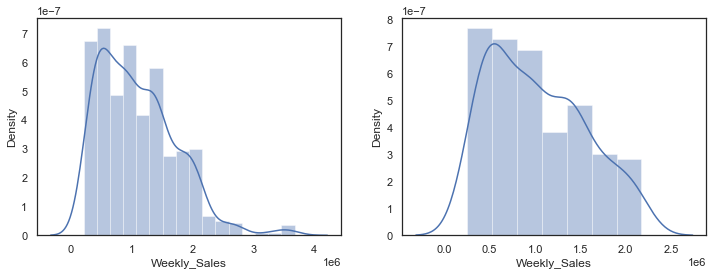

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [172]:
# submission.to_csv('./Data/submission17.csv', index=False)